# Evaluation and Metrics
Run a small test set (10–20 Qs) to sanity-check correctness and refusals.

### Load and / or store model with auto-CUDA 

In [24]:
import os
# Needed for ealuating test_prompts 
import time, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sentence_transformers import SentenceTransformer


# Tell Hugging Face to skip TensorFlow/Flax so they never import TensorFlow (TF).
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

# Quiet TF logs if something still pulls it in.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 1=INFO, 2=WARNING, 3=ERROR

In [ ]:
import os, sys
import importlib.util
from pathlib import Path
repo_root = Path(r"\Paste\Path\to SlideHunter\BASE repo folder Here")
helper_path = Path(repo_root) / "scripts" / "nb01_helper.py"
spec = importlib.util.spec_from_file_location("scripts.nb01_helper", helper_path)
h = importlib.util.module_from_spec(spec)
spec.loader.exec_module(h)

load_store = h.load_store        # Load data from saved csv/json files helper functions from nb01_helper
make_router = h.make_router      # Functions to make router and search
search = h.search                # Function to search--Canvas pages, slides, etc.
print("🛫Force-loaded nb01_helper by path")


# Pull just what functions we need
load_store = h.load_store
make_router = h.make_router
search = h.search

Force-loaded nb01_helper by path ✅


In [26]:
# Load saved artifacts (FAISS index, fact snippets, metadata)
# These were previously built & saved with save_store() function.
index, facts, metas = load_store()
# ensure query embeddings must match the ones stored in FAISS
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
# Sanity check: index size must align with number of facts/metas
assert index.ntotal == len(facts) == len(metas), "Index/facts/metas are misaligned!"
# Precompute route embeddings for auto domain detection ("technical", "career", etc.)
router = make_router(model)


In [ ]:
# Test prompts to evaluate
# These are the same type of questions students might ask about the course.
# They cover one domain (technical).
test_prompts_1dom = [
    "When does phase 2 begin?",
    "Any way of saying June 9th?",
    "Where can I find my instructor's email?",
    "Under Course Team Contact Information?",
    "What was the last TLAB about?",
    "An explanation of making a music recommender.",
    "What lecture slides do we review pivot tables?",
    "What lecture slides did we learn about control flow?",
    "Can you give me a bullet point list of the most important concepts covered about SQL?",
    "I'd like to know when pahse 2 commences, so I can prepare, thanks!",
    "Give me a summary of P2W2's material.",
    "Where did we define precision vs. recall?",
    "Explain the linear regression formula.",
    "What are the steps for PCA?",
    "What's the difference between an L1 and L2 penalty?",
    "Where can I find information on?",
    "So I want to know more about XGboost and its trade-offs with AdaBoost.",
    "Which slides describe the bias-variance trade-off (summary + cite both pages)?",
    "pls where did u all show that 'log loss' thing ??? and that \"slide w/ the blue curve comparing roc stuff—where?\"",
    "Can I see other students grades??", 
    
]

In [ ]:
# Test prompts to evaluate
# These are the same type of questions students might ask about the course.
# They cover both domains (technical and career) and various topics.
test_prompts_2dom = [
    "When does phase 2 begin?",
    "Any way of saying June 9th?",
    "Where can I find my instructor's email?",
    "Under Course Team Contact Information?",
    "What was the last TLAB about?",
    "An explanation of making a music recommender.",
    # LinkedIn / Networking
    "How do I optimize my LinkedIn profile for recruiters?",
    "Where are the slides that explain how to grow your professional network?",
    "What lecture covered strategies for reaching out to alumni on LinkedIn?",
    # Interviews
    "Which lecture explains how to answer behavioral interview questions?",
    "Where did we cover the STAR method for interviews?",
    "What module discussed common technical interview mistakes?",
    "What lecture slides do we review pivot tables?",
    "What lecture slides did we learn about control flow?",
    "Can you give me a bullet point list of the most important concepts covered about SQL?",
    "I'd like to know when pahse 2 commences, so I can prepare, thanks!",
    "Give me a summary of P2W2's material.",
     # Resumes / Cover Letters
    "Where can I find tips on writing a strong resume?",
    "What slides talk about tailoring a cover letter for job applications?",
    "Are there resources on creating a portfolio or GitHub for job search?",    
    "Where did we define precision vs. recall?",
    "Explain the linear regression formula.",
    "What are the steps for PCA?",
    # Hackathons / Career Events
    "Was there a session on preparing for hackathons?",
    "Where can I find resources for showcasing projects at a career fair?",
    "What lecture explained how to network effectively during career events?",
    "What's the difference between an L1 and L2 penalty?",
    "Where can I find information on?",
    "So I want to know more about XGboost and its trade-offs with AdaBoost.",
    "Which slides describe the bias-variance trade-off (summary + cite both pages)?",
    "pls where did u all show that 'log loss' thing ??? and that \"slide w/ the blue curve comparing roc stuff—where?\"",
    "Can I see other students grades??", 
    # Career Readiness / Instructor Resources
    "Where can I find contact info for the career services team?",
    "What lecture slides provide advice on building an elevator pitch?",
    "Are there resources on mock interviews or practice sessions with instructors?"
]



In [ ]:
# Run each query through the search function
# When testing Both domains(tech and career), change test_prompts_1dom to test_prompts_2dom
# To test route="auto" for router to decide domain, or "technical" or "career" to force a domain
for q in test_prompts_2dom:
    scope, hits = search(
        query=q,               # natural language question
        model=model,           # sentence-transformers embedder
        index=index,           # FAISS vector index
        facts=facts,           # list of fact text snippets
        metas=metas,           # metadata dicts (course/module/item info)
        router_emb=router,     # domain router embeddings
        k=4,                   # return top-4 matches
        scope="auto"           # let router decide technical/career/all
    )

    # Print query + resolved scope
    print(f"\nQ: {q}   [scope={scope}]")

    # If no results, notify and skip
    if not hits:
        print("  (no hits)")
        continue

    # Otherwise, print out citation-style matches with score
    for h in hits:
        m = h["meta"]
        cite = f"{m['course_name']} > {m['module_name']} > {m['item_title']} ({m['type']})"
        if m.get("url"):  # add URL if available
            cite += f"  [{m['url']}]"
        print(f"  {h['score']:.3f} :: {cite}")



Q: When does phase 2 begin?   [scope=all]
  0.476 :: IF '25 Data Science Cohort A > P2W12 (8/25 - 8/29) End of Phase Project Week > [TEPP] Phase 2 Portfolio Project Checkpoint #2 (Due 8/27) (Assignment)
  0.434 :: IF '25 Data Science Cohort A > P2W11 (8/18-8/22) Agents & End of Phase Project > [TEPP] Phase 2 Portfolio Project Checkpoint #1 (Due 8/20) (Assignment)
  0.426 :: IF '25 Data Science Cohort A > P2W11 (8/18-8/22) Agents & End of Phase Project > [TEPP] Phase 2 Portfolio Project (Due 8/29) (Assignment)
  0.425 :: IF '25 Data Science Cohort A > P2W1 (6/9-6/13) Python & SQL Review > 💻 W1D1 (6/9) Introduction to Phase 2 (Page)  [https://tkh.instructure.com/courses/172/pages/w1d1-6-slash-9-introduction-to-phase-2]

Q: Any way of saying June 9th?   [scope=technical]
  0.230 :: Foundations Course > Week 1: Foundations For Success (Jan. 27th-Jan. 30th) > (W1D1) After Class Assignment: Reflecting on Your Support System (Assignment)
  0.225 :: IF '25 Data Science Cohort A > P2W7 (7/21-7

### 🧪 Evaluate Test Prompts (latency + scope + citation)

In [ ]:
# -------------------------------------------------------------------
# Optional: set BASE once (repo root) via env var or hardcoded fallback
# Also if modifying additional prompts or saving to csv file
# BASE is only used for saving the CSV; if unset, we fallback to CWD/outputs.
# -------------------------------------------------------------------

# Point this ONCE to the repo root (hardcoded in env var)
# Will use when serch() import from scripts.nb01_helper and loaded 
BASE = Path(os.getenv("SLIDEHUNTER_BASE", os.getcwd())).resolve()

# Evaluate a lis of test queries againts the search() retriever
# with auto-routing and top-1 citations.
def evaluate_prompts(prompts, k=4, scope="auto", save_csv=True):
    """
    Evaluate retrieval quality over a list of prompts using the `search` retriever.

    For each prompt, this:
      1) Calls `search(...)` (auto-routing by default),
      2) Records latency (seconds), chosen scope, top-1 score,
      3) Builds a human-readable citation (course > module > item [+url]),
      4) Adds a wall-clock timestamp for when the row was evaluated.

    NOTE:
      - This function expects the following globals to already exist in the notebook:
        `model` (SentenceTransformer), `index` (FAISS), `facts` (List[str]),
        `metas` (List[dict]), `router` (from make_router(model)), and `BASE` (Path).
      - `latency_s` is the elapsed time (seconds) for the search call.

    Args:
        prompts (List[str]): Test questions.
        k (int, optional): Top-k to retrieve (default 4).
        scope (str, optional): "auto", "technical", "career", or "all" (default "auto").
        save_csv (bool, optional): Save results to <BASE>/outputs/eval_prompts.csv (default True).

    Returns:
        pd.DataFrame: One row per prompt with latency, top-1 score, domain, citation, and timestamp.
    """
    rows = []
    for q in prompts:
        t0 = time.time()  # start timer
        # Stateless helper; we pass in all artifacts explicitly
        sc, hits = search(
            query=q,               # natural-language question
            model=model,           # SentenceTransformers embedder (must match index build)
            index=index,           # FAISS vector index
            facts=facts,           # fact snippets (aligned with FAISS vectors)
            metas=metas,           # metadata dicts (aligned 1:1 with facts)
            router_emb=router,     # domain router embeddings
            k=k,                   # top-k results to return
            scope=scope            # "auto" lets router pick technical/career/all
        )

        dt = time.time() - t0     # elapsed seconds for this query
        ts = datetime.now().isoformat(timespec="seconds")  # wall-clock timestamp

        if hits:
            h0 = hits[0]          # top-1
            m = h0["meta"]
            # Human-readable citation (include URL if available)
            cite = f"{m['course_name']} > {m['module_name']} > {m['item_title']} ({m['type']})"
            if m.get("url"):
                cite += f" [{m['url']}]"

            rows.append({
                "query": q,
                "scope": sc,                       # scope selected (e.g., 'technical', 'career', 'all')
                "latency_s": round(dt, 3),         # elapsed time in SECONDS (this is your timing metric)
                "top_score": round(h0["score"], 3),
                "top_domain": m.get("domain"),
                "citation": cite,
                "evaluated_at": ts,                # wall-clock time the row was produced
            })
        else:
            rows.append({
                "query": q,
                "scope": sc,
                "latency_s": round(dt, 3),
                "top_score": None,
                "top_domain": None,
                "citation": "(no hits)",
                "evaluated_at": ts,
            })

    # Build the result table
    df = pd.DataFrame(rows)

    # Pretty-print the table in the notebook
    with pd.option_context("display.max_colwidth", 100, "display.width", 140):
        print(df.to_string(index=False))

    # Optionally save to CSV
    if save_csv:
        outdir = Path(BASE) / "outputs"
        outdir.mkdir(parents=True, exist_ok=True)
        path = outdir / "eval_prompts.csv" # When testing Both domains(tech and career), change filename to eval_prompts_2dom.csv
        df.to_csv(path, index=False)
        # print(f"saved: {path}")

    # Short summary section
    coverage = (df["citation"] != "(no hits)").mean()
    avg_score = df["top_score"].dropna().mean() if df["top_score"].notna().any() else None
    print(f"\nCoverage: {coverage:.0%}   Avg top_score: {None if avg_score is None else round(avg_score, 3)}")
    print("By domain (top-1):")
    print(df["top_domain"].value_counts(dropna=True))

    return df

# run on our test prompts to evaluate output
_ = evaluate_prompts(test_prompts_2dom, k=4, scope="auto", save_csv=True)

                                                                                                           query     scope  latency_s  top_score top_domain                                                                                                                                                                                                                                   citation        evaluated_at
                                                                                        When does phase 2 begin?       all      0.030      0.476  technical                                                                                      IF '25 Data Science Cohort A > P2W12 (8/25 - 8/29) End of Phase Project Week > [TEPP] Phase 2 Portfolio Project Checkpoint #2 (Due 8/27) (Assignment) 2025-08-30T23:34:52
                                                                                     Any way of saying June 9th? technical      0.023      0.230  technical                       

In [32]:
## Some EDA of outputs/eval_prompts.csv
sh_df = pd.read_csv("../outputs/eval_prompts.csv")
sh_df.head()

,query,scope,latency_s,top_score,top_domain,citation,evaluated_at
0,When does phase 2 begin?,all,0.030,0.476,technical,IF '25 Data Science Cohort A > P2W12 (8/25 - 8...,2025-08-30T23:34:52
1,Any way of saying June 9th?,technical,0.023,0.230,technical,Foundations Course > Week 1: Foundations For S...,2025-08-30T23:34:52
2,Where can I find my instructor's email?,technical,0.026,0.332,technical,IF '25 Data Science Cohort A > Fellow Resource...,2025-08-30T23:34:52
3,Under Course Team Contact Information?,all,0.023,0.444,technical,IF '25 Data Science Cohort A > Fellow Resource...,2025-08-30T23:34:52
4,What was the last TLAB about?,technical,0.025,0.334,technical,IF '25 Data Science Cohort A > P2W9 (8/4-8/8) ...,2025-08-30T23:34:52


## Initial observations / insights

- All 20 queries returned hits (100% coverage).
- Latency is consistently ~0.01–0.04s (fast enough for real-time).
-  Scores cluster in the 0.3–0.57 range → many are above the LOW_SCORE_REFUSAL (0.4), but a few (0.23, 0.29, 0.33) may be borderline/confusing.
- Top domain is entirely technical → router needs “career” style questions to validate.
- Next step: 
  - Test additonal 10–15 career-related test prompts (resume, cover letters, interview prep, LinkedIn).

## Univariate Analysis

In [ ]:
# descriptive stats
sh_df.describe()

,latency_s,top_score
count,20.000000,20.000000
mean,0.025450,0.407450
std,0.008029,0.094736
min,0.016000,0.230000
25%,0.017000,0.340000
50%,0.028000,0.380000
75%,0.032000,0.473000
max,0.037000,0.577000


In [ ]:
# Table properties like dtypes, non-null counts, etc.
sh_df.info         

<bound method DataFrame.info of                                                 query      scope  latency_s  \
0                            When does phase 2 begin?        all      0.035   
1                         Any way of saying June 9th?  technical      0.028   
2             Where can I find my instructor's email?  technical      0.030   
3              Under Course Team Contact Information?        all      0.037   
4                       What was the last TLAB about?  technical      0.030   
5       An explanation of making a music recommender.  technical      0.032   
6      What lecture slides do we review pivot tables?  technical      0.035   
7   What lecture slides did we learn about control...  technical      0.017   
8   Can you give me a bullet point list of the mos...  technical      0.031   
9   I'd like to know when pahse 2 commences, so I ...        all      0.016   
10              Give me a summary of P2W2's material.        all      0.036   
11          Where di

In [34]:
# print
print(sh_df.isna().sum()) 

#    
print(sh_df.scope.value_counts())

#
print(sh_df.top_domain.value_counts())

query           0
scope           0
latency_s       0
top_score       0
top_domain      0
citation        0
evaluated_at    0
dtype: int64
scope
technical    15
all          13
career        7
Name: count, dtype: int64
top_domain
technical    27
career        8
Name: count, dtype: int64


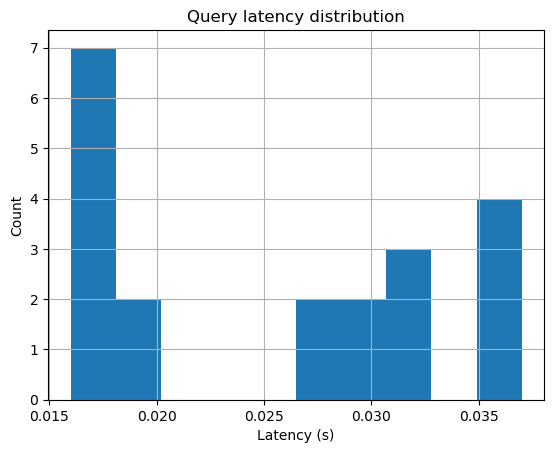

In [ ]:
sh_df["latency_s"].describe()

sh_df["latency_s"].hist(bins=10)
plt.xlabel("Latency (s)")
plt.ylabel("Count")
plt.title("Query latency distribution")
plt.show()


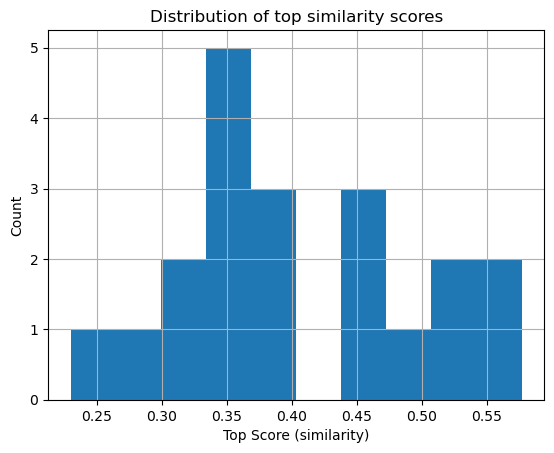

In [ ]:
sh_df["top_score"].describe()

sh_df["top_score"].hist(bins=10)
plt.xlabel("Top Score (similarity)")
plt.ylabel("Count")
plt.title("Distribution of top similarity scores")
plt.show()


In [ ]:
# Query-level observations
# View whether scope="auto" queries behave differently vs. technical.
# do a split,agg, combine on these
tp_score = sh_df.groupby("scope")["top_score"].mean()
tp_score


scope
all          0.43625
technical    0.38825
Name: top_score, dtype: float64

In [ ]:
tp_laten = sh_df.groupby("scope")["latency_s"].mean()
tp_laten

scope
all          0.02575
technical    0.02525
Name: latency_s, dtype: float64

In [ ]:
coverage = (sh_df["citation"] != "(no hits)").mean()
print(f"Coverage: {coverage:.0%}")

Coverage: 100%


In [ ]:
tp_dom = sh_df["top_domain"].value_counts(normalize=True)
tp_dom

top_domain
technical    1.0
Name: proportion, dtype: float64

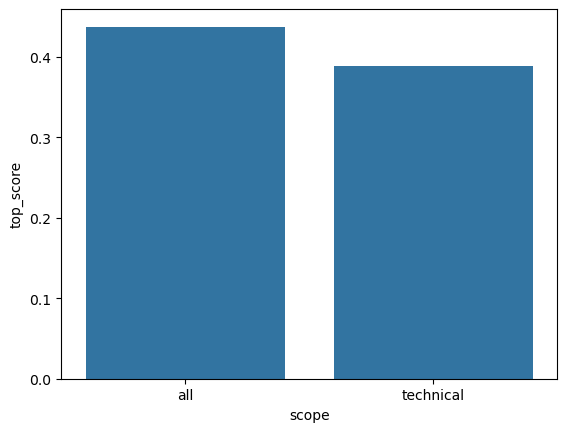

In [ ]:
sns.barplot(data=sh_df, x="scope", y="top_score", errorbar=('ci', False))
plt.show()

In [ ]:
# subset of dataframe
top_score_df = sh_df[["top_score", "query", "citation"]].copy()

# top five records
top_score_df.head()


,top_score,query,citation
0,0.476,When does phase 2 begin?,IF '25 Data Science Cohort A > P2W12 (8/25 - 8...
1,0.230,Any way of saying June 9th?,Foundations Course > Week 1: Foundations For S...
2,0.332,Where can I find my instructor's email?,IF '25 Data Science Cohort A > Fellow Resource...
3,0.444,Under Course Team Contact Information?,IF '25 Data Science Cohort A > Fellow Resource...
4,0.334,What was the last TLAB about?,IF '25 Data Science Cohort A > P2W9 (8/4-8/8) ...


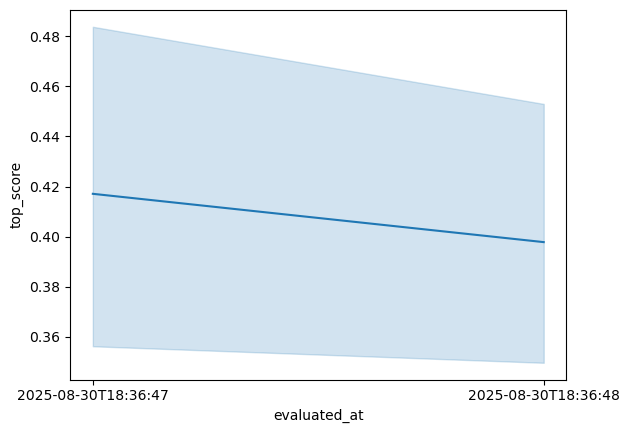

In [ ]:
sns.lineplot(data=sh_df, x="evaluated_at", y="top_score")
plt.show()

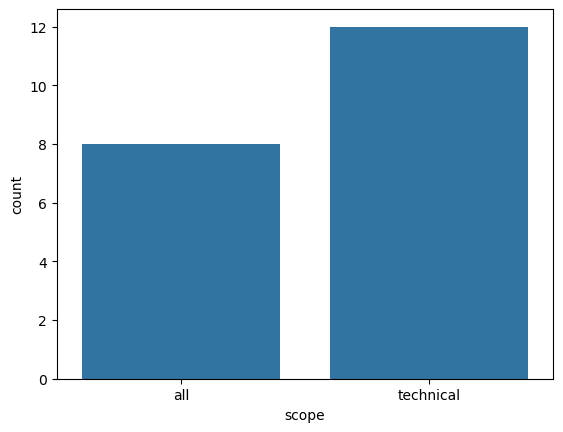

In [ ]:
sns.countplot(data=sh_df, x="scope")
plt.show()

## Bivariate Analysis